# Notebook to prepare the yolo dataset creation pipeline

In [32]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import os
import numpy as np
import cv2

from data_utils import generate_labels
import matplotlib


# Checking how to get images from raster without black background

In [39]:
raster_file = rasterio.open("test.TIF")
data = raster_file.read(1,masked=True)
print(data)
print('what is data.mask?')
print(data.mask)
a = np.where(~data.mask)
print(a)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
what is data.mask?
False
(array([0]),)


In [40]:
raster_file.transform
print(raster_file.nodata)
print(raster_file.nodatavals)

None
(None,)


In [41]:
msk = raster_file.read_masks(1)
print(msk)

print(data.shape)
print(msk.shape)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
(7161, 7941)
(7161, 7941)


In [42]:
tmp_msk = mask(raster_file)

TypeError: mask() missing 1 required positional argument: 'shapes'

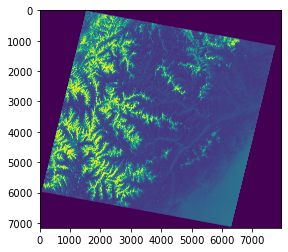

In [28]:
matplotlib.pyplot.imshow(data)

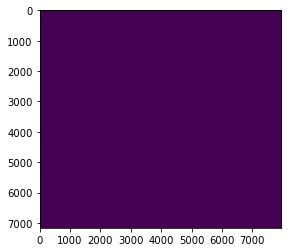

In [27]:
 matplotlib.pyplot.imshow(msk)

In [3]:
# Cropping the raster file

def crop_raster_to_data(raster_file, output_file):
    with rasterio.open(raster_file) as src:
        # Read the raster as a masked array
        data = src.read(1, masked=True)

        # Find the bounding box of the valid data
        indices = np.where(~data.mask)
        rows, cols = indices[0], indices[1]
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)

        # Create a window to read the cropped raster
        window = rasterio.windows.Window(
            col_off=min_col, row_off=min_row,
            width=max_col - min_col + 1, height=max_row - min_row + 1)

        # Read the data in the window
        cropped_data = src.read(window=window)

        # Update the transform based on the window
        new_transform = rasterio.windows.transform(window, src.transform)

        # Define the new profile based on the updated dimensions and transform
        new_profile = src.profile.copy()
        new_profile.update({
            "height": window.height,
            "width": window.width,
            "transform": new_transform
        })

        # Write the cropped data to a new raster
        with rasterio.open(output_file, 'w', **new_profile) as dest:
            dest.write(cropped_data)

input_raster = 'test.TIF'
output_cropped_raster = 'test_cropped.TIF'
crop_raster_to_data(input_raster, output_cropped_raster)


IndexError: tuple index out of range

# Checking the weird labels

In [7]:
weird_label_path = '/Users/vihaan/Workspace/Local_AI_Earth/Data_Manipulation/Mosaic/labels/LE07_L2SP_2015_02_T1_SR_BC_M249.txt'
shapefile_path = '/Users/vihaan/Workspace/Local_AI_Earth/DataManipulation/Mosaic/shape_patches/LE07_L2SP_2015_02_T1_SR_BC_M249.shp'

# Read the shapefile

shapefile = gpd.read_file(shapefile_path)

In [8]:
print(shapefile)

          Area         Trigger Date_ided                 Post_Image    Extent  \
0     1233.890  4/25 mainshock       6/3  BhoteKosi3_Jun_3_R3C2.tif  complete   
1     6167.360  4/25 mainshock       6/3  BhoteKosi3_Jun_3_R3C2.tif  complete   
2     2782.370  4/25 mainshock       6/3  BhoteKosi3_Jun_3_R3C2.tif  complete   
3      954.757  4/25 mainshock       6/3  BhoteKosi3_Jun_3_R3C2.tif  complete   
4      328.429  4/25 mainshock       6/3  BhoteKosi3_Jun_3_R3C2.tif  complete   
...        ...             ...       ...                        ...       ...   
3491  1662.430  4/25 mainshock       5/3             GE imagery 5/3  complete   
3492   814.935  4/25 mainshock       5/3             GE imagery 5/3  complete   
3493   581.163  4/25 mainshock       5/3             GE imagery 5/3  complete   
3494   325.296  4/25 mainshock       5/3             GE imagery 5/3  complete   
3495   952.816  4/25 mainshock       5/3             GE imagery 5/3  complete   

                    Source 

In [ ]:
# Checking the textfile



## Visualising labels and data

In [1]:
# Attempting printing labels on an image
from data_utils import print_labels_on_image


# Reading a labels file as an example
label_path = 'ls_data/labels/LE07_L1TP_130038_19991209_20170215_01_T1_BC56.txt'
'/Users/vihaan/Workspace/Local_AI_Earth/Data_Manipulation/Mosaic/labels/LE07_L2SP_2015_02_T1_SR_BC_M249'
image_path = 'ls_data/images/LE07_L1TP_130038_19991209_20170215_01_T1_BC56.jpg'

print_labels_on_image(image_path, label_path)

## Trying to convert shapefiles (.shp) of each patch to YOLO labels format

In [2]:
#Testing the whole flow
import os

foldername = "Mosaic"
# Obtain all the 'filename's from the images folder without the extension
filenames = [os.path.splitext(filename)[0] for filename in os.listdir(foldername + "/image_patches")]

print(filenames)


['LE07_L2SP_2015_02_T1_SR_BC_M1', 'LE07_L2SP_2015_02_T1_SR_BC_M106', 'LE07_L2SP_2015_02_T1_SR_BC_M112', 'LE07_L2SP_2015_02_T1_SR_BC_M489', 'LE07_L2SP_2015_02_T1_SR_BC_M338', 'LE07_L2SP_2015_02_T1_SR_BC_M462', 'LE07_L2SP_2015_02_T1_SR_BC_M33', 'LE07_L2SP_2015_02_T1_SR_BC_M304', 'LE07_L2SP_2015_02_T1_SR_BC_M310', 'LE07_L2SP_2015_02_T1_SR_BC_M476', 'LE07_L2SP_2015_02_T1_SR_BC_M27', 'LE07_L2SP_2015_02_T1_SR_BC_M258', 'LE07_L2SP_2015_02_T1_SR_BC_M516', 'LE07_L2SP_2015_02_T1_SR_BC_M270', 'LE07_L2SP_2015_02_T1_SR_BC_M264', 'LE07_L2SP_2015_02_T1_SR_BC_M502', 'LE07_L2SP_2015_02_T1_SR_BC_M265', 'LE07_L2SP_2015_02_T1_SR_BC_M503', 'LE07_L2SP_2015_02_T1_SR_BC_M517', 'LE07_L2SP_2015_02_T1_SR_BC_M271', 'LE07_L2SP_2015_02_T1_SR_BC_M259', 'LE07_L2SP_2015_02_T1_SR_BC_M311', 'LE07_L2SP_2015_02_T1_SR_BC_M26', 'LE07_L2SP_2015_02_T1_SR_BC_M477', 'LE07_L2SP_2015_02_T1_SR_BC_M32', 'LE07_L2SP_2015_02_T1_SR_BC_M463', 'LE07_L2SP_2015_02_T1_SR_BC_M305', 'LE07_L2SP_2015_02_T1_SR_BC_M339', 'LE07_L2SP_2015_02_T1_SR_

In [9]:
total_len = len(filenames)
counter = 0

for picname in filenames:
    generate_labels(picname)
    counter += 1

    print(counter, '/', total_len, 'done')

1 / 580 done
2 / 580 done
3 / 580 done
4 / 580 done
5 / 580 done
6 / 580 done
7 / 580 done
8 / 580 done
9 / 580 done
10 / 580 done
11 / 580 done
12 / 580 done
13 / 580 done
14 / 580 done
15 / 580 done
16 / 580 done
17 / 580 done
18 / 580 done
19 / 580 done
20 / 580 done
21 / 580 done
22 / 580 done
23 / 580 done
24 / 580 done
25 / 580 done
26 / 580 done
27 / 580 done
28 / 580 done
29 / 580 done
30 / 580 done
31 / 580 done
32 / 580 done
33 / 580 done
34 / 580 done
35 / 580 done
36 / 580 done
37 / 580 done
38 / 580 done
39 / 580 done
40 / 580 done
41 / 580 done
42 / 580 done
43 / 580 done
44 / 580 done
45 / 580 done
46 / 580 done
47 / 580 done
48 / 580 done
49 / 580 done
50 / 580 done
51 / 580 done
52 / 580 done
53 / 580 done
54 / 580 done
55 / 580 done
56 / 580 done
57 / 580 done
58 / 580 done
59 / 580 done
60 / 580 done
61 / 580 done
62 / 580 done
63 / 580 done
64 / 580 done
65 / 580 done
66 / 580 done
67 / 580 done
68 / 580 done
69 / 580 done
70 / 580 done
71 / 580 done
72 / 580 done
7

KeyboardInterrupt: 

In [ ]:
# Visualising an image and labels

import numpy as np  
import cv2


def print_labels_on_image(image_path, yolo_label_format):
    '''
    image_path: path to image
    yolo_label_format: path to label file
    '''

    # Load image
    image = cv2.imread(image_path)

    # Load labels
    with open(yolo_label_format,'r'):
        labels = [line.rstrip('\n') for line in open(yolo_label_format)]

    # Get image dimensions
    image_height, image_width, _ = image.shape

    # Scaling the labels (x labels are scaled by image_width and y labels are scaled by image_height)
    x_scale = image_width
    y_scale = image_height

    # Loop through labels
    for label in labels:

        # Converting string labels list to integer
        flat_coordinates = convert_string_list_to_float(label)[1:]

        # Scaling up the coordinates to x_scale and y_scale
        for i in range(len(flat_coordinates)):

            # x values
            if i % 2 == 0:
                flat_coordinates[i] *= x_scale
            # y values
            else:
                flat_coordinates[i] *= y_scale

        # Draw polygon
        polygon_coordinates = np.array(flat_coordinates).reshape((-1,1,2)).astype(np.int32)
        cv2.polylines(image, [polygon_coordinates], True, (0, 255, 0), 1)

    # Display image
    cv2.imshow('image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



